In [1]:
import datetime; regenerate= f'http://www.climsystems.com Lu.S {datetime.date.today()}'
import xarray as xr, gc, tqdm, os
import numpy as np

%matplotlib inline

def preprocess(ds):
    # ds = ds.drop('wgs_1984', errors='ignore')
    matching_dims = [dim for dim in ds.dims if 'longitude' in dim.lower() or 'latitude' in dim.lower()]
    rename_dict = {dim: 'lon' if 'longitude' in dim.lower() else 'lat' for dim in matching_dims}
    ds = ds.rename(rename_dict)
    ds = ds.rename({i:i.lower() 
                    if i.lower() in ['points','time','year','month','depth'] 
                    else i.lower()[:3] for i in ds.coords}
                  )
    ds['lat'] = ds['lat'].astype('float32')
    ds['lon'] = ds['lon'].astype('float32')
    # if max(ds.lon) > 180:
    ds = ds.assign_coords(lon=(ds.lon % 360)); ds = ds.sortby(ds.lon); ds = ds.sortby(ds.lat, ascending=False)
    # # else:
    # ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)); ds = ds.sortby(['lon', 'lat']); ds = ds.sortby(ds.lat, ascending=False)
    #ds = ds.sortby(ds.lon); ds = ds.sortby(ds.lat, ascending=False)
    return ds

In [2]:
root = '/media/AsustorFour_Public/project_output/Rio_Tinto_VAR_project/Data'

In [3]:
vn1 = 'wndgust10m'
output_path1 = f'{root}/BARRA_wind_gust_future'
os.makedirs(f'{output_path1}/', exist_ok=True)

In [4]:
max_wind = xr.open_mfdataset(f'{root}/BARRA_daymax/*{vn1}*.nc',
    preprocess = preprocess,
    engine='h5netcdf', chunks='auto', parallel=True)['max_'+vn1+'_daily']


/tmp/ipykernel_564236/2773137784.py:12: UserWarning: rename 'lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({i:i.lower()
/tmp/ipykernel_564236/2773137784.py:12: UserWarning: rename 'lon' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({i:i.lower()
/tmp/ipykernel_564236/2773137784.py:12: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({i:i.lower()
/tmp/ipykernel_564236/2773137784.py:12: UserWarning: rename 'lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({i:i.lower()
/tmp/ipykernel_564236/2773137784.py:12: UserWarning: rename 'lon' to 'lon' doe

In [ ]:
grouped_max_wind = max_wind.groupby('time.month')

In [ ]:
 grouped_max_wind.to_dataset(name='max_wind_speed').astype('float32').to_netcdf(f'{output_path1}/base_line_monthly2.nc')#.astype('float32').to_netcdf(f'{output_path1}/base_line_monthly2.nc')
 print(grouped_max_wind)

In [59]:
max_wind.lon

<xarray.DataArray 'lon' (lon: 1200)>
array([ 65.055  ,  65.165  ,  65.275  , ..., 196.725  , 196.83499, 196.945  ],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 65.06 65.17 65.28 65.39 ... 196.6 196.7 196.8 196.9
    hei      float64 10.0

In [ ]:
grouped_max_wind = grouped_max_wind.drop('height')

In [ ]:
grouped_max_wind

In [5]:
path_ensemble='/media/AsustorOne_Shared/AR6_patterns_changes_for_API'
ensemble = xr.open_mfdataset(f'{path_ensemble}/Global_Extreme_Wind_Speed_change.nc4',
        preprocess = preprocess,   
        engine='h5netcdf', chunks='auto')['change']

/tmp/ipykernel_564236/2773137784.py:12: UserWarning: rename 'year' to 'year' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({i:i.lower()
/tmp/ipykernel_564236/2773137784.py:12: UserWarning: rename 'ari' to 'ari' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({i:i.lower()
/tmp/ipykernel_564236/2773137784.py:12: UserWarning: rename 'ssp' to 'ssp' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({i:i.lower()
/tmp/ipykernel_564236/2773137784.py:12: UserWarning: rename 'lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({i:i.lower()
/tmp/ipykernel_564236/2773137784.py:12: UserWarning: rename 'lon' to 'lon' doe

In [6]:
ensemble

,Array,Chunk
Bytes,4.87 GiB,44.49 MiB
Shape,"(12, 4, 7, 360, 720, 15)","(6, 2, 3, 180, 360, 5)"
Count,289 Tasks,144 Chunks
Type,float32,numpy.ndarray


In [7]:
ensemble_ssp_245_50p_2030 = ensemble[7,1,3,:,:,2]
ensemble_ssp_245_50p_2070 = ensemble[7,1,3,:,:,10]
ensemble_ssp_585_50p_2030 = ensemble[7,3,3,:,:,2]
ensemble_ssp_585_50p_2070 = ensemble[7,3,3,:,:,10]

ensemble_ssp_245_95p_2030 = ensemble[7,1,6,:,:,2]
ensemble_ssp_245_95p_2070 = ensemble[7,1,6,:,:,10]
ensemble_ssp_585_95p_2030 = ensemble[7,3,6,:,:,2]
ensemble_ssp_585_95p_2070 = ensemble[7,3,6,:,:,10]

ensemble_ssp_245_05p_2030 = ensemble[7,1,0,:,:,2]
ensemble_ssp_245_05p_2070 = ensemble[7,1,0,:,:,10]
ensemble_ssp_585_05p_2030 = ensemble[7,3,0,:,:,2]
ensemble_ssp_585_05p_2070 = ensemble[7,3,0,:,:,10]


In [8]:
# ensemble_best
# ensemble_best = ensemble_best.drop('pth')
#grouped_max_wind
print(ensemble_ssp_585_95p_2030)
print(ensemble_ssp_585_95p_2070)

<xarray.DataArray 'change' (lat: 360, lon: 720)>
dask.array<getitem, shape=(360, 720), dtype=float32, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
    year     int32 2030
    ari      int32 100
    ssp      int32 585
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
    pth      float64 95.0
Attributes:
    regenerate:  http://www.climsystems.com J.Yu 2021-06-10
    units:       %
<xarray.DataArray 'change' (lat: 360, lon: 720)>
dask.array<getitem, shape=(360, 720), dtype=float32, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
    year     int32 2070
    ari      int32 100
    ssp      int32 585
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
    pth      float64 95.0
Attributes:
    regenerate:  http://www.climsystems.com J.Yu 2021-06-10
    units

In [9]:
ensemble_ssp_245_50p_2030 =  ensemble_ssp_245_50p_2030.interp(lon=max_wind.lon,lat=max_wind.lat)
ensemble_ssp_245_50p_2070 =  ensemble_ssp_245_50p_2070.interp(lon=max_wind.lon,lat=max_wind.lat)
ensemble_ssp_585_50p_2030 =  ensemble_ssp_585_50p_2030.interp(lon=max_wind.lon,lat=max_wind.lat)
ensemble_ssp_585_50p_2070 =  ensemble_ssp_585_50p_2070.interp(lon=max_wind.lon,lat=max_wind.lat)

ensemble_ssp_245_95p_2030 = ensemble_ssp_245_95p_2030.interp(lon=max_wind.lon,lat=max_wind.lat)
ensemble_ssp_245_95p_2070 = ensemble_ssp_245_95p_2070.interp(lon=max_wind.lon,lat=max_wind.lat)
ensemble_ssp_585_95p_2030 = ensemble_ssp_585_95p_2030.interp(lon=max_wind.lon,lat=max_wind.lat)
ensemble_ssp_585_95p_2070 = ensemble_ssp_585_95p_2070.interp(lon=max_wind.lon,lat=max_wind.lat)

ensemble_ssp_245_05p_2030 = ensemble_ssp_245_05p_2030.interp(lon=max_wind.lon,lat=max_wind.lat)
ensemble_ssp_245_05p_2070 = ensemble_ssp_245_05p_2070.interp(lon=max_wind.lon,lat=max_wind.lat)
ensemble_ssp_585_05p_2030 = ensemble_ssp_585_05p_2030.interp(lon=max_wind.lon,lat=max_wind.lat)
ensemble_ssp_585_05p_2070 = ensemble_ssp_585_05p_2070.interp(lon=max_wind.lon,lat=max_wind.lat)

In [10]:
ensemble_ssp_245_50p_2030

<xarray.DataArray 'change' (lat: 768, lon: 1200)>
dask.array<transpose, shape=(768, 1200), dtype=float32, chunksize=(768, 1200), chunktype=numpy.ndarray>
Coordinates:
    year     int32 2030
    ari      int32 100
    ssp      int32 245
    pth      float64 50.0
  * lon      (lon) float32 65.06 65.17 65.28 65.39 ... 196.6 196.7 196.8 196.9
  * lat      (lat) float32 19.43 19.32 19.21 19.1 ... -64.72 -64.83 -64.94
    hei      float64 10.0
Attributes:
    regenerate:  http://www.climsystems.com J.Yu 2021-06-10
    units:       %

In [11]:
future_ssp_245_50p_2030 =  (1.0 + ensemble_ssp_245_50p_2030  /100.0) * max_wind
future_ssp_245_50p_2070 =  (1.0 + ensemble_ssp_245_50p_2070 /100.0)  * max_wind
future_ssp_585_50p_2030 =  (1.0 + ensemble_ssp_585_50p_2030 /100.0)  * max_wind
future_ssp_585_50p_2070 =  (1 + ensemble_ssp_585_50p_2070 /100.0)  * max_wind

future_ssp_245_95p_2030 = (1.0 + ensemble_ssp_245_95p_2030 /100.0)  * max_wind
future_ssp_245_95p_2070 = (1.0 + ensemble_ssp_245_95p_2070 /100.0)  * max_wind
future_ssp_585_95p_2030 = (1.0 + ensemble_ssp_585_95p_2030 /100.0)  * max_wind
future_ssp_585_95p_2070 = (1.0 + ensemble_ssp_585_95p_2070 /100.0)  * max_wind

future_ssp_245_05p_2030 = (1.0 + ensemble_ssp_245_05p_2030 /100.0)  * max_wind
future_ssp_245_05p_2070 = (1.0 + ensemble_ssp_245_05p_2070 /100.0)  * max_wind
future_ssp_585_05p_2030 = (1.0 + ensemble_ssp_585_05p_2030 /100.0)  * max_wind
future_ssp_585_05p_2070 = (1.0 + ensemble_ssp_585_05p_2070 /100.0)  * max_wind

In [12]:
future_ssp_245_50p_2030 =  future_ssp_245_50p_2030.drop('year')
future_ssp_245_50p_2070 =  future_ssp_245_50p_2070.drop('year')
future_ssp_585_50p_2030 =  future_ssp_585_50p_2030.drop('year')
future_ssp_585_50p_2070 =  future_ssp_585_50p_2070.drop('year')

future_ssp_245_95p_2030 = future_ssp_245_95p_2030.drop('year')
future_ssp_245_95p_2070 = future_ssp_245_95p_2070.drop('year')
future_ssp_585_95p_2030 = future_ssp_585_95p_2030.drop('year')
future_ssp_585_95p_2070 = future_ssp_585_95p_2070.drop('year')

future_ssp_245_05p_2030 = future_ssp_245_05p_2030.drop('year')
future_ssp_245_05p_2070 = future_ssp_245_05p_2070.drop('year')
future_ssp_585_05p_2030 = future_ssp_585_05p_2030.drop('year')
future_ssp_585_05p_2070 = future_ssp_585_05p_2070.drop('year')





In [63]:
output_path2 = f'{root}/BARRA_wind_gust_future/'
    
threshold = 27.78

max_wind_above_threshold = max_wind.where (max_wind > threshold)
max_wind_above_threshold = max_wind_above_threshold.where(np.isnan(max_wind_above_threshold),other=1)

    # print(max_wind_above_threshold
max_wind_above_threshold = (max_wind_above_threshold
    # .rename({'latitude':'lat','longitude':'lon'}) 
.resample(time='1Y', skipna=True).sum() 
    .assign_attrs(regenerate=regenerate)
).load()
max_wind_above_threshold.name = 'day_num_above_thres'
max_wind_above_threshold.astype('float32').to_netcdf(f'{output_path2}/max_wind_full_time_series.nc')
max_wind_above_threshold.mean(axis = 0).astype('float32').to_netcdf(f'{output_path2}/max_wind_base_line.nc')


In [17]:
    output_path2 = f'{root}/BARRA_wind_gust_future/'
    
    threshold = 27.78

    future_ssp_245_50p_2030_above_threshold = future_ssp_245_50p_2030.where (future_ssp_245_50p_2030 > threshold)
    future_ssp_245_50p_2030_above_threshold = future_ssp_245_50p_2030_above_threshold.where(np.isnan(future_ssp_245_50p_2030_above_threshold),other=1)

    # print(max_wind_above_threshold
    future_ssp_245_50p_2030_above_threshold = (future_ssp_245_50p_2030_above_threshold
    # .rename({'latitude':'lat','longitude':'lon'}) 
    .resample(time='1Y', skipna=True).sum() 
    .assign_attrs(regenerate=regenerate)
    ).load()
    future_ssp_245_50p_2030_above_threshold.name = 'day_num_above_thres'
    future_ssp_245_50p_2030_above_threshold.astype('float32').to_netcdf(f'{output_path2}/future_ssp_245_50p_2030_full_time_series.nc')
    future_ssp_245_50p_2030_above_threshold.mean(axis = 2).astype('float32').to_netcdf(f'{output_path2}/future_ssp_245_50p_2030.nc')

KeyboardInterrupt: 

In [16]:
    future_ssp_585_50p_2030_above_threshold = future_ssp_585_50p_2030.where (future_ssp_585_50p_2030 > threshold)
    future_ssp_585_50p_2030_above_threshold = future_ssp_585_50p_2030_above_threshold.where(np.isnan(future_ssp_585_50p_2030_above_threshold),other=1)

    # print(max_wind_above_threshold
    future_ssp_585_50p_2030_above_threshold = (future_ssp_585_50p_2030_above_threshold
    # .rename({'latitude':'lat','longitude':'lon'}) 
    .resample(time='1Y', skipna=True).sum() 
    .assign_attrs(regenerate=regenerate)
    ).load()
    future_ssp_585_50p_2030_above_threshold.name = 'day_num_above_thres'
    future_ssp_585_50p_2030_above_threshold.astype('float32').to_netcdf(f'{output_path2}/future_ssp_585_50p_2030_full_time_series.nc')
    future_ssp_585_50p_2030_above_threshold.mean(axis = 2).astype('float32').to_netcdf(f'{output_path2}/future_ssp_585_50p_2030.nc')

In [17]:
    future_ssp_245_50p_2070_above_threshold = future_ssp_245_50p_2070.where (future_ssp_245_50p_2070 > threshold)
    future_ssp_245_50p_2070_above_threshold = future_ssp_245_50p_2070_above_threshold.where(np.isnan(future_ssp_245_50p_2070_above_threshold),other=1)

    # print(max_wind_above_threshold
    future_ssp_245_50p_2070_above_threshold = (future_ssp_245_50p_2070_above_threshold
    # .rename({'latitude':'lat','longitude':'lon'}) 
    .resample(time='1Y', skipna=True).sum() 
    .assign_attrs(regenerate=regenerate)
    ).load()
    future_ssp_245_50p_2070_above_threshold.name = 'day_num_above_thres'
    future_ssp_245_50p_2070_above_threshold.astype('float32').to_netcdf(f'{output_path2}/future_ssp_245_50p_2070_full_time_series.nc')
    future_ssp_245_50p_2070_above_threshold.mean(axis = 2).astype('float32').to_netcdf(f'{output_path2}/future_ssp_245_50p_2070.nc')

In [18]:
    future_ssp_585_50p_2070_above_threshold = future_ssp_585_50p_2070.where (future_ssp_585_50p_2070 > threshold)
    future_ssp_585_50p_2070_above_threshold = future_ssp_585_50p_2070_above_threshold.where(np.isnan(future_ssp_585_50p_2070_above_threshold),other=1)

    # print(max_wind_above_threshold
    future_ssp_585_50p_2070_above_threshold = (future_ssp_585_50p_2070_above_threshold
    # .rename({'latitude':'lat','longitude':'lon'}) 
    .resample(time='1Y', skipna=True).sum() 
    .assign_attrs(regenerate=regenerate)
    ).load()
    future_ssp_585_50p_2070_above_threshold.name = 'day_num_above_thres'
    future_ssp_585_50p_2070_above_threshold.astype('float32').to_netcdf(f'{output_path2}/future_ssp_585_50p_2070_full_time_series.nc')
    future_ssp_585_50p_2070_above_threshold.mean(axis = 2).astype('float32').to_netcdf(f'{output_path2}/future_ssp_585_50p_2070.nc')

In [19]:
    future_ssp_245_95p_2030_above_threshold = future_ssp_245_95p_2030.where (future_ssp_245_95p_2030 > threshold)
    future_ssp_245_95p_2030_above_threshold = future_ssp_245_95p_2030_above_threshold.where(np.isnan(future_ssp_245_95p_2030_above_threshold),other=1)

    # print(max_wind_above_threshold
    future_ssp_245_95p_2030_above_threshold = (future_ssp_245_95p_2030_above_threshold
    # .rename({'latitude':'lat','longitude':'lon'}) 
    .resample(time='1Y', skipna=True).sum() 
    .assign_attrs(regenerate=regenerate)
    ).load()
    future_ssp_245_95p_2030_above_threshold.name = 'day_num_above_thres'
    future_ssp_245_95p_2030_above_threshold.astype('float32').to_netcdf(f'{output_path2}/future_ssp_245_95p_2030_full_time_series.nc')
    future_ssp_245_95p_2030_above_threshold.mean(axis = 2).astype('float32').to_netcdf(f'{output_path2}/future_ssp_245_95p_2030.nc')

In [14]:
    output_path2 = f'{root}/BARRA_wind_gust_future/'
    threshold = 27.78
    
    future_ssp_245_95p_2070_above_threshold = future_ssp_245_95p_2070.where (future_ssp_245_95p_2070 > threshold)
    future_ssp_245_95p_2070_above_threshold = future_ssp_245_95p_2070_above_threshold.where(np.isnan(future_ssp_245_95p_2070_above_threshold),other=1)

    # print(max_wind_above_threshold
    future_ssp_245_95p_2070_above_threshold = (future_ssp_245_95p_2070_above_threshold
    # .rename({'latitude':'lat','longitude':'lon'}) 
    .resample(time='1Y', skipna=True).sum() 
    .assign_attrs(regenerate=regenerate)
    ).load()
    future_ssp_245_95p_2070_above_threshold.name = 'day_num_above_thres'
    future_ssp_245_95p_2070_above_threshold.astype('float32').to_netcdf(f'{output_path2}/future_ssp_245_95p_2070_full_time_series.nc')
    future_ssp_245_95p_2070_above_threshold.mean(axis = 2).astype('float32').to_netcdf(f'{output_path2}/future_ssp_245_95p_2070.nc')   


In [21]:
    future_ssp_585_95p_2030_above_threshold = future_ssp_585_95p_2030.where (future_ssp_585_95p_2030 > threshold)
    future_ssp_585_95p_2030_above_threshold = future_ssp_585_95p_2030_above_threshold.where(np.isnan(future_ssp_585_95p_2030_above_threshold),other=1)
    
    # print(max_wind_above_threshold
    future_ssp_585_95p_2030_above_threshold = (future_ssp_585_95p_2030_above_threshold
    # .rename({'latitude':'lat','longitude':'lon'}) 
    .resample(time='1Y', skipna=True).sum() 
    .assign_attrs(regenerate=regenerate)
    ).load()
    future_ssp_585_95p_2030_above_threshold.name = 'day_num_above_thres'
    future_ssp_585_95p_2030_above_threshold.astype('float32').to_netcdf(f'{output_path2}/future_ssp_585_95p_2030_full_time_series.nc')
    future_ssp_585_95p_2030_above_threshold.mean(axis = 2).astype('float32').to_netcdf(f'{output_path2}/future_ssp_585_95p_2030.nc')

In [22]:
    future_ssp_585_95p_2070_above_threshold = future_ssp_585_95p_2070.where (future_ssp_585_95p_2070 > threshold)
    future_ssp_585_95p_2070_above_threshold = future_ssp_585_95p_2070_above_threshold.where(np.isnan(future_ssp_585_95p_2070_above_threshold),other=1)
    
    # print(max_wind_above_threshold
    future_ssp_585_95p_2070_above_threshold = (future_ssp_585_95p_2070_above_threshold
    # .rename({'latitude':'lat','longitude':'lon'}) 
    .resample(time='1Y', skipna=True).sum() 
    .assign_attrs(regenerate=regenerate)
    ).load()
    future_ssp_585_95p_2070_above_threshold.name = 'day_num_above_thres'
    future_ssp_585_95p_2070_above_threshold.astype('float32').to_netcdf(f'{output_path2}/future_ssp_585_95p_2070_full_time_series.nc')
    future_ssp_585_95p_2070_above_threshold.mean(axis = 2).astype('float32').to_netcdf(f'{output_path2}/future_ssp_585_95p_2070.nc')

In [15]:
output_path2 = f'{root}/BARRA_wind_gust_future/'
    
threshold = 27.78

future_ssp_585_05p_2070_above_threshold = future_ssp_585_05p_2070.where (future_ssp_585_05p_2070 > threshold)
future_ssp_585_05p_2070_above_threshold = future_ssp_585_05p_2070_above_threshold.where(np.isnan(future_ssp_585_05p_2070_above_threshold),other=1)
    
    # print(max_wind_above_threshold
future_ssp_585_05p_2070_above_threshold = (future_ssp_585_05p_2070_above_threshold
    # .rename({'latitude':'lat','longitude':'lon'}) 
.resample(time='1Y', skipna=True).sum() 
.assign_attrs(regenerate=regenerate)
).load()
future_ssp_585_05p_2070_above_threshold.name = 'day_num_above_thres'
future_ssp_585_05p_2070_above_threshold.astype('float32').to_netcdf(f'{output_path2}/future_ssp_585_05p_2070_full_time_series.nc')
future_ssp_585_05p_2070_above_threshold.mean(axis = 2).astype('float32').to_netcdf(f'{output_path2}/future_ssp_585_05p_2070.nc')

In [16]:
future_ssp_585_05p_2030_above_threshold = future_ssp_585_05p_2030.where (future_ssp_585_05p_2030 > threshold)
future_ssp_585_05p_2030_above_threshold = future_ssp_585_05p_2030_above_threshold.where(np.isnan(future_ssp_585_05p_2030_above_threshold),other=1)

# print(max_wind_above_threshold
future_ssp_585_05p_2030_above_threshold = (future_ssp_585_05p_2030_above_threshold
# .rename({'latitude':'lat','longitude':'lon'}) 
.resample(time='1Y', skipna=True).sum() 
.assign_attrs(regenerate=regenerate)
).load()
future_ssp_585_05p_2030_above_threshold.name = 'day_num_above_thres'
future_ssp_585_05p_2030_above_threshold.astype('float32').to_netcdf(f'{output_path2}/future_ssp_585_05p_2030_full_time_series.nc')
future_ssp_585_05p_2030_above_threshold.mean(axis = 2).astype('float32').to_netcdf(f'{output_path2}/future_ssp_585_05p_2030.nc')

In [17]:
future_ssp_245_05p_2070_above_threshold = future_ssp_245_05p_2070.where (future_ssp_245_05p_2070 > threshold)
future_ssp_245_05p_2070_above_threshold = future_ssp_245_05p_2070_above_threshold.where(np.isnan(future_ssp_245_05p_2070_above_threshold),other=1)
# print(max_wind_above_threshold
future_ssp_245_05p_2070_above_threshold = (future_ssp_245_05p_2070_above_threshold
# .rename({'latitude':'lat','longitude':'lon'}) 
.resample(time='1Y', skipna=True).sum() 
.assign_attrs(regenerate=regenerate)
).load()
future_ssp_245_05p_2070_above_threshold.name = 'day_num_above_thres'
future_ssp_245_05p_2070_above_threshold.astype('float32').to_netcdf(f'{output_path2}/future_ssp_245_05p_2070_full_time_series.nc')
future_ssp_245_05p_2070_above_threshold.mean(axis = 2).astype('float32').to_netcdf(f'{output_path2}/future_ssp_245_05p_2070.nc')   

In [18]:

future_ssp_245_05p_2030_above_threshold = future_ssp_245_05p_2030.where (future_ssp_245_05p_2030 > threshold)
future_ssp_245_05p_2030_above_threshold = future_ssp_245_05p_2030_above_threshold.where(np.isnan(future_ssp_245_05p_2030_above_threshold),other=1)

# print(max_wind_above_threshold
future_ssp_245_05p_2030_above_threshold = (future_ssp_245_05p_2030_above_threshold
# .rename({'latitude':'lat','longitude':'lon'}) 
.resample(time='1Y', skipna=True).sum() 
.assign_attrs(regenerate=regenerate)
).load()
future_ssp_245_05p_2030_above_threshold.name = 'day_num_above_thres'
future_ssp_245_05p_2030_above_threshold.astype('float32').to_netcdf(f'{output_path2}/future_ssp_245_05p_2030_full_time_series.nc')
future_ssp_245_05p_2030_above_threshold.mean(axis = 2).astype('float32').to_netcdf(f'{output_path2}/future_ssp_245_05p_2030.nc')

In [17]:
future_ssp_245_50p_2030_above_threshold

<xarray.DataArray 'day_num_above_thres' (lat: 768, lon: 1200, time: 30)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [13., 13.,  7., ...,  8., 17.,  0.],
        [14., 13.,  7., ...,  7., 17.,  0.],
        [14., 12.,  7., ...,  7., 17.,  0.]],

       [[12., 11.,  9., ..., 10., 25.,  1.],
        [11., 11.,  8., ..., 10., 25.,  1.],
        [11., 11.,  6., ..., 10., 25.,  1.],
        ...,
        [14., 13.,  7., ...,  9., 17.,  0.],
        [14., 12.,  7., ...,  8., 17.,  0.],
        [14., 12.,  6., ...,  8., 17.,  0.]],

       [[12., 11.,  8., ..., 10., 27.,  1.],
        [10.,  9.,  9., ..., 10., 27.,  1.],
        [11., 10.,  9., ..., 11., 27.,  1.],
        ...,
        [13., 13.,  6., ...,  9., 17.,  0.],
        [13., 13.,  5., ...,  8., 17.,  0.],
        [13., 12.,  5., ...,  9., 16.,  0.]]], dtype=float32)
Coordinates:
    ari      int32 100
    ssp      int32 245
    pth      float64 50.0
  * lon      (lon) float32 65.06 65.17 65.28 65.39 ... 196.6 196.7 196.8 196.9
  * lat      (lat) float32 19.43 19.32 19.21 19.1 ... -64.72 -64.83 -64.94
    hei      float64 10.0
  * time     (time) datetime64[ns] 1990-12-31 1991-12-31 ... 2019-12-31
Attributes:
    regenerate:  http://www.climsystems.com Lu.S 2023-06-29

In [19]:
import Jpkg as J
import datetime; regenerate= f'http://www.climsystems.com Lu.S {datetime.date.today()}'
import xarray as xr, gc, tqdm, os
import numpy as np

%matplotlib inline

In [20]:
max_wind_base_line = xr.open_mfdataset(f'{root}/BARRA_wind_gust_future/max_wind_base_line.nc')['day_num_above_thres']

future_ssp_245_50p_2030_above_threshold_mean = xr.open_mfdataset(f'{root}/BARRA_wind_gust_future/future_ssp_245_50p_2030.nc')['day_num_above_thres']
future_ssp_245_50p_2070_above_threshold_mean = xr.open_mfdataset(f'{root}/BARRA_wind_gust_future/future_ssp_245_50p_2070.nc')['day_num_above_thres']
future_ssp_585_50p_2030_above_threshold_mean = xr.open_mfdataset(f'{root}/BARRA_wind_gust_future/future_ssp_585_50p_2030.nc')['day_num_above_thres']
future_ssp_585_50p_2070_above_threshold_mean = xr.open_mfdataset(f'{root}/BARRA_wind_gust_future/future_ssp_585_50p_2070.nc')['day_num_above_thres']

future_ssp_245_95p_2030_above_threshold_mean = xr.open_mfdataset(f'{root}/BARRA_wind_gust_future/future_ssp_245_95p_2030.nc')['day_num_above_thres']
future_ssp_245_95p_2070_above_threshold_mean = xr.open_mfdataset(f'{root}/BARRA_wind_gust_future/future_ssp_245_95p_2070.nc')['day_num_above_thres']
future_ssp_585_95p_2030_above_threshold_mean = xr.open_mfdataset(f'{root}/BARRA_wind_gust_future/future_ssp_585_95p_2030.nc')['day_num_above_thres']
future_ssp_585_95p_2070_above_threshold_mean = xr.open_mfdataset(f'{root}/BARRA_wind_gust_future/future_ssp_585_95p_2070.nc')['day_num_above_thres']

future_ssp_245_05p_2030_above_threshold_mean = xr.open_mfdataset(f'{root}/BARRA_wind_gust_future/future_ssp_245_05p_2030.nc')['day_num_above_thres']
future_ssp_245_05p_2070_above_threshold_mean = xr.open_mfdataset(f'{root}/BARRA_wind_gust_future/future_ssp_245_05p_2070.nc')['day_num_above_thres']
future_ssp_585_05p_2030_above_threshold_mean = xr.open_mfdataset(f'{root}/BARRA_wind_gust_future/future_ssp_585_05p_2030.nc')['day_num_above_thres']
future_ssp_585_05p_2070_above_threshold_mean = xr.open_mfdataset(f'{root}/BARRA_wind_gust_future/future_ssp_585_05p_2070.nc')['day_num_above_thres']

In [21]:
max_lon = max(future_ssp_245_95p_2030_above_threshold_mean.lon)
min_lon = min(future_ssp_245_95p_2030_above_threshold_mean.lon)
max_lat = max(future_ssp_245_95p_2030_above_threshold_mean.lat)
min_lat = min(future_ssp_245_95p_2030_above_threshold_mean.lat)
lon_new = np.arange(min_lon-0.11/2.0,max_lon+0.05+0.11/2.0,0.05)
lat_new = np.arange(min_lat-0.11/2.0,max_lat+0.05+0.11/2.0,0.05)
lat_new = lat_new [::-1]

In [22]:
lat_new

array([ 19.50000031,  19.45000031,  19.40000031, ..., -64.89999969,
       -64.94999969, -64.99999969])

In [23]:
max_wind_base_line = max_wind_base_line.interp(lon  =  lon_new, lat = lat_new)

future_ssp_245_50p_2030_above_threshold_mean = future_ssp_245_50p_2030_above_threshold_mean.interp(lon  =  lon_new, lat = lat_new)
future_ssp_245_50p_2070_above_threshold_mean = future_ssp_245_50p_2070_above_threshold_mean.interp(lon  =  lon_new, lat = lat_new)
future_ssp_585_50p_2030_above_threshold_mean = future_ssp_585_50p_2030_above_threshold_mean.interp(lon  =  lon_new, lat = lat_new)
future_ssp_585_50p_2070_above_threshold_mean = future_ssp_585_50p_2070_above_threshold_mean.interp(lon  =  lon_new, lat = lat_new)

future_ssp_245_95p_2030_above_threshold_mean = future_ssp_245_95p_2030_above_threshold_mean.interp(lon  =  lon_new, lat = lat_new)
future_ssp_245_95p_2070_above_threshold_mean = future_ssp_245_95p_2070_above_threshold_mean.interp(lon  =  lon_new, lat = lat_new)
future_ssp_585_95p_2030_above_threshold_mean = future_ssp_585_95p_2030_above_threshold_mean.interp(lon  =  lon_new, lat = lat_new)
future_ssp_585_95p_2070_above_threshold_mean = future_ssp_585_95p_2070_above_threshold_mean.interp(lon  =  lon_new, lat = lat_new)

future_ssp_245_05p_2030_above_threshold_mean = future_ssp_245_05p_2030_above_threshold_mean.interp(lon  =  lon_new, lat = lat_new)
future_ssp_245_05p_2070_above_threshold_mean = future_ssp_245_05p_2070_above_threshold_mean.interp(lon  =  lon_new, lat = lat_new)
future_ssp_585_05p_2030_above_threshold_mean = future_ssp_585_05p_2030_above_threshold_mean.interp(lon  =  lon_new, lat = lat_new)
future_ssp_585_05p_2070_above_threshold_mean = future_ssp_585_05p_2070_above_threshold_mean.interp(lon  =  lon_new, lat = lat_new)

In [24]:
 shp = '/home/climsystems/LuSUN/Data/vic_shape/vic.shp'
 
 tmp1 =  J.fshape2xr(future_ssp_245_50p_2030_above_threshold_mean, shp)
 tmp2 =  J.fshape2xr(future_ssp_245_50p_2070_above_threshold_mean, shp)
 tmp3 =  J.fshape2xr(future_ssp_585_50p_2030_above_threshold_mean, shp)
 tmp4 =  J.fshape2xr(future_ssp_585_50p_2070_above_threshold_mean, shp)
 tmp5 =  J.fshape2xr(future_ssp_245_95p_2030_above_threshold_mean, shp)
 tmp6 =  J.fshape2xr(future_ssp_245_95p_2070_above_threshold_mean, shp)
 tmp7 =  J.fshape2xr(future_ssp_585_95p_2030_above_threshold_mean, shp)
 tmp8 =  J.fshape2xr(future_ssp_585_95p_2070_above_threshold_mean, shp)

 tmp9 =  J.fshape2xr(future_ssp_245_05p_2030_above_threshold_mean, shp)
 tmp10 =  J.fshape2xr(future_ssp_245_05p_2070_above_threshold_mean, shp)
 tmp11 =  J.fshape2xr(future_ssp_585_05p_2030_above_threshold_mean, shp)
 tmp12 =  J.fshape2xr(future_ssp_585_05p_2070_above_threshold_mean, shp)


 tmp0 = J.fshape2xr(max_wind_base_line, shp)

 

In [25]:
J.savetif(J.nc2xr(tmp1), 'future_ssp_245_50p_2030.tif')
J.savetif(J.nc2xr(tmp2), 'future_ssp_245_50p_2070.tif')
J.savetif(J.nc2xr(tmp3), 'future_ssp_585_50p_2030.tif')
J.savetif(J.nc2xr(tmp4), 'future_ssp_585_50p_2070.tif')
J.savetif(J.nc2xr(tmp5), 'future_ssp_245_95p_2030.tif')
J.savetif(J.nc2xr(tmp6), 'future_ssp_245_95p_2070.tif')
J.savetif(J.nc2xr(tmp7), 'future_ssp_585_95p_2030.tif')
J.savetif(J.nc2xr(tmp8), 'future_ssp_585_95p_2070.tif')


J.savetif(J.nc2xr(tmp9), 'future_ssp_245_05p_2030.tif')
J.savetif(J.nc2xr(tmp10), 'future_ssp_245_05p_2070.tif')
J.savetif(J.nc2xr(tmp11), 'future_ssp_585_05p_2030.tif')
J.savetif(J.nc2xr(tmp12), 'future_ssp_585_05p_2070.tif')
J.savetif(J.nc2xr(tmp0), 'max_wind_base_line.tif')



Output: future_ssp_245_50p_2030.tif ......

Output: future_ssp_245_50p_2070.tif ......

Output: future_ssp_585_50p_2030.tif ......

Output: future_ssp_585_50p_2070.tif ......

Output: future_ssp_245_95p_2030.tif ......

Output: future_ssp_245_95p_2070.tif ......

Output: future_ssp_585_95p_2030.tif ......

Output: future_ssp_585_95p_2070.tif ......

Output: future_ssp_245_05p_2030.tif ......

Output: future_ssp_245_05p_2070.tif ......

Output: future_ssp_585_05p_2030.tif ......

Output: future_ssp_585_05p_2070.tif ......

Output: max_wind_base_line.tif ......


{'nodata': nan,
 'driver': 'GTiff',
 'crs': 'epsg:4326',
 'compress': 'lzw',
 'count': 1,
 'dtype': 'float32',
 'width': 180,
 'height': 105,
 'transform': Affine(0.05, 0.0, 140.9750003052,
        0.0, -0.05, -33.9749996948)}

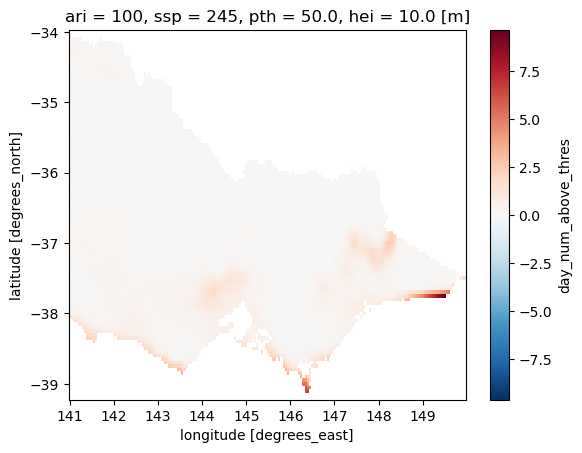

In [80]:
tmp2.plot()

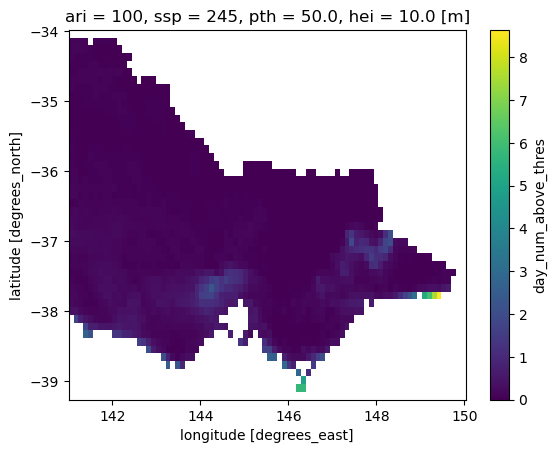

In [50]:
# tmp1.plot()

In [16]:
output_path2 = f'{root}/BARRA_wind_gust_future/'

tmp1.to_netcdf(f'{output_path2}/future_ssp_245_50p_2030_above_threshold_vic.nc')
tmp2.to_netcdf(f'{output_path2}/future_ssp_245_50p_2070_above_threshold_vic.nc')
tmp3.to_netcdf(f'{output_path2}/future_ssp_585_50p_2030_above_threshold_vic.nc')
tmp4.to_netcdf(f'{output_path2}/future_ssp_585_50p_2070_above_threshold_vic.nc')
tmp5.to_netcdf(f'{output_path2}/future_ssp_245_95p_2030_above_threshold_vic.nc')
tmp6.to_netcdf(f'{output_path2}/future_ssp_245_95p_2070_above_threshold_vic.nc')
tmp7.to_netcdf(f'{output_path2}/future_ssp_585_95p_2030_above_threshold_vic.nc')
tmp8.to_netcdf(f'{output_path2}/future_ssp_585_95p_2070_above_threshold_vic.nc')

tmp0.to_netcdf(f'{output_path2}/max_wind_base_line_vic.nc')

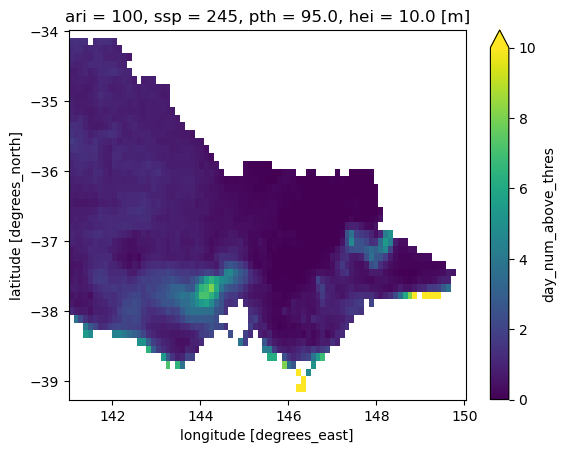

In [23]:
tmp8.plot(vmax = 10)

In [ ]:
ensemble_best = ensemble_best.interp_like(grouped_max_wind)#,dims=grouped_max_wind.dims, coords=grouped_max_wind.coords) xr.DataArray(

In [ ]:
# grouped_max_wind
ensemble_best

In [ ]:
import pandas as pd
curve = pd.read_csv(path_ensemble+'/IPCC_AR6_GMT_curves.csv')


In [ ]:
curve['SSP1-1.9:mid'][2]

In [ ]:
future = grouped_max_wind